In this problem, we are given n stocks to chose everyday during the m-day period and want to maximize the total return. Here I first assume the stock return is stationary and I use epsilon-greedy bandit method:

In [278]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import display
import math
from scipy.optimize import minimize

In [279]:
def stock_return_generate(m, n, standard_deviation = 1):
    stock_returns = []
    stock_mean_returns = list(np.random.uniform(-10, 10, n))
    for i in range(n):
        stock_return = np.random.standard_t(3, size = m)
        stock_return = np.array(stock_return)*standard_deviation + stock_mean_returns[i]
        stock_returns.append(stock_return)
    stock_returns = np.array(stock_returns)
    return stock_returns, stock_mean_returns

In [280]:
def get_optimal_price(stock_mean_returns):
    return stock_mean_returns.index(max(stock_mean_returns))

In the epsilon greedy algorithm, the agent have probability epsilon to choose a stock randomly from the basket or pick the stock with the maximum estimated average return with probability 1-epsilon.

In [281]:
class epsilon_greedy_agent():
    def __init__(self, epsilon, m, n):
        self.stock_number = n
        self.epsilon = epsilon
        self.estimated_price_return = [0]*n
        self.stock_chosen_time = [0]*n
        self.regret_function_value = 0
        self.average_return = 0
        self.optimal_action = 0
        
    def pick_stock(self):
        number1 = random.uniform(0, 1)
        if number1 <= self.epsilon:
            chosen_stock = random.randrange(self.stock_number)
        else:
            chosen_stock = self.estimated_price_return.index(max(self.estimated_price_return))
        return chosen_stock
    
    def update(self, stock_values, chosen_stock, optimal_stock, i):
        self.stock_chosen_time[chosen_stock] += 1
        self.estimated_price_return[chosen_stock] += (stock_values[chosen_stock] - self.estimated_price_return[chosen_stock])/self.stock_chosen_time[chosen_stock]
        self.regret_function_value += stock_values[optimal_stock] - stock_values[chosen_stock]
        self.average_return += (stock_values[chosen_stock] - self.average_return)/i 
        if chosen_stock == optimal_stock:
            self.optimal_action += 1

In [282]:
def epsilon_greedy(m, epsilon, n, standard_deviation):
    stock_returns, stock_mean_returns = stock_return_generate(m, n, standard_deviation)
    optimal_stock = get_optimal_price(stock_mean_returns)
    investor_1 = epsilon_greedy_agent(epsilon, m, n)
    for i in range(m):
        chosen_stock = investor_1.pick_stock()
        stock_values = stock_returns[:, i]
        investor_1.update(stock_values, chosen_stock, optimal_stock, i + 1)
    optimal_action_perc = 100*investor_1.optimal_action/m
    return investor_1.average_return, optimal_action_perc, investor_1.regret_function_value
        
    

In [291]:
def average_return(epsilon, m, n, standard_deviation):
    repeat = 1000
    average_return_value = 0
    for i in range(repeat):
        average_return, optimal_action_perc, regret_function_value = epsilon_greedy(m, epsilon, n, standard_deviation)
        average_return_value += (average_return - average_return_value)/(i + 1)
    return -average_return

In [292]:
def optimize_epsilon(m, n, standard_deviation):
    epsilon_0 = 0.1
    res = minimize(average_return, epsilon_0, tol=1e-3, args=(m, n, standard_deviation))
    display(res)


In [293]:
optimize_epsilon(1000, 10, 1)

      fun: -8.735401757874458
 hess_inv: array([[7.21878748e-13]])
      jac: array([33840327.30204153])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 54
      nit: 1
     njev: 21
   status: 2
  success: False
        x: array([0.10008702])

In [275]:
def visualization():
    m = 1000
    n = 10
    steps = list(range(10, m))
    average_returns = []
    optimal_action_percs = []
    regret_function_values = []
    standard_deviation = 1
    upper_bound_epsilon = pow(m, -1/3)*pow(n*math.log(m), 1/3)
    epsilons = [ 0.1, 0.2, 0.3, upper_bound_epsilon]
    for j in range(len(epsilons)):
        average_return_ = []
        optimal_action_perc_ = []
        regret_function_value_ = []
        for i in range(10, m):
            average_return, optimal_action_perc, regret_function_value = epsilon_greedy(i, epsilons[j], n, standard_deviation)
            average_return_.append(average_return)
            optimal_action_perc_.append(optimal_action_perc)
            regret_function_value_.append(regret_function_value)
        average_returns.append(average_return_)
        optimal_action_percs.append(optimal_action_perc_)
        regret_function_values.append(regret_function_value_)
        
    plt.figure(1)
    for j in range(len(epsilons)):
        plt.plot(steps, average_returns[j], label = f'epsilon = {epsilons[j]}')
        plt.xlabel('steps')
        plt.ylabel('average return')
        plt.legend()
    
    plt.figure(2)
    for j in range(len(epsilons)):
        plt.plot(steps, optimal_action_percs[j], label = f'epsilon = {epsilons[j]}')
        plt.xlabel('steps')
        plt.ylabel('optimal action %')
        plt.legend()
    
    plt.figure(3)
    for j in range(len(epsilons)):
        plt.plot(steps, regret_function_values[j], label = f'epsilon = {epsilons[j]}')
        plt.xlabel('steps')
        plt.ylabel('regret value')
        plt.legend()
    plt.show()
    

<IPython.core.display.Javascript object>


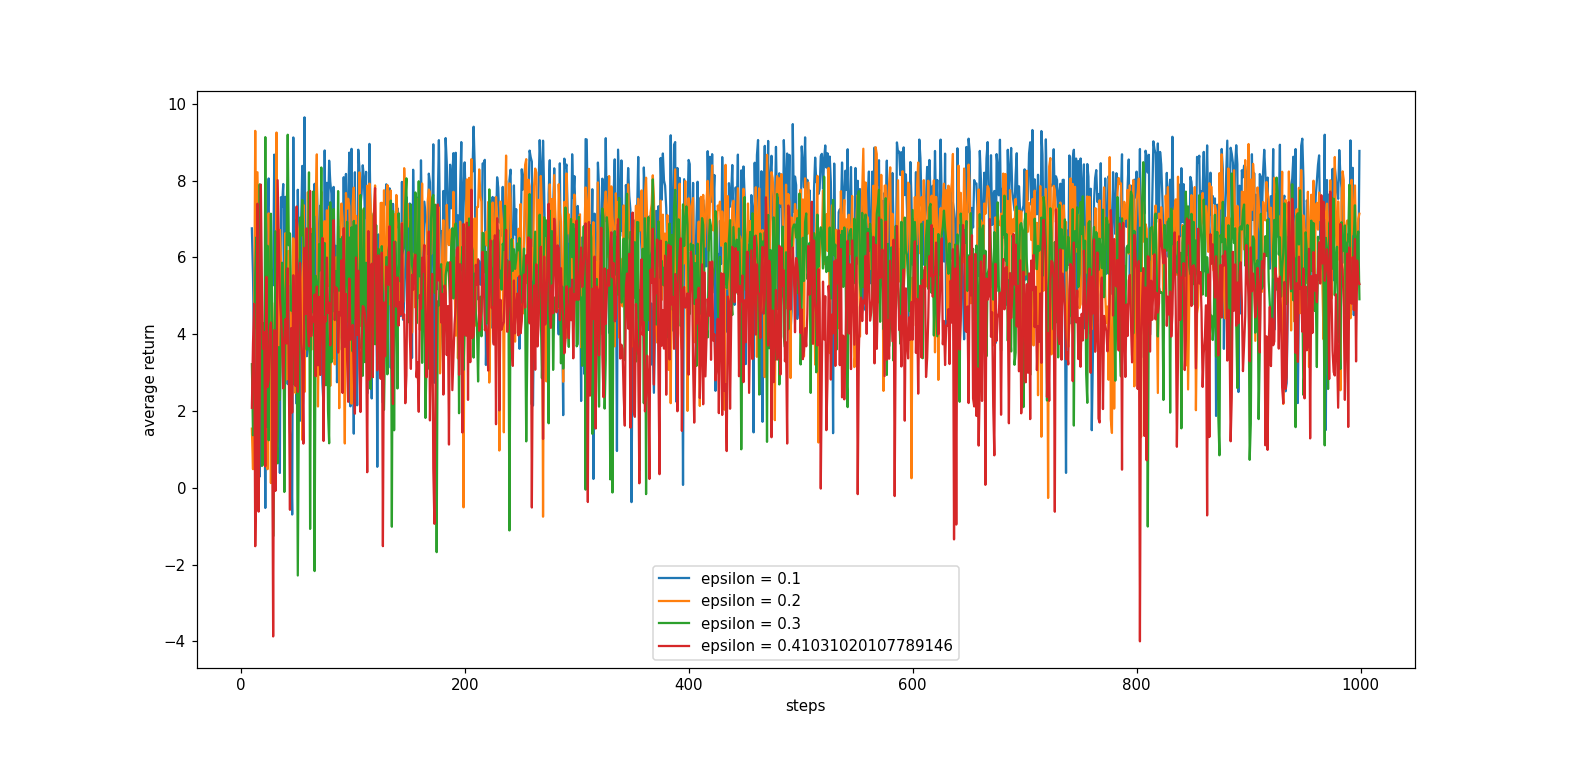

<IPython.core.display.Javascript object>


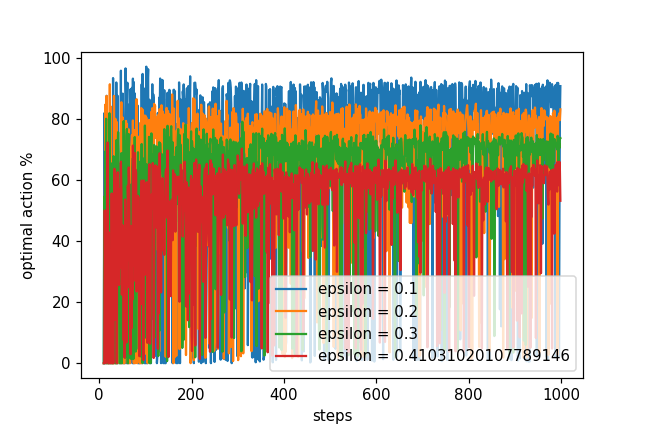

<IPython.core.display.Javascript object>


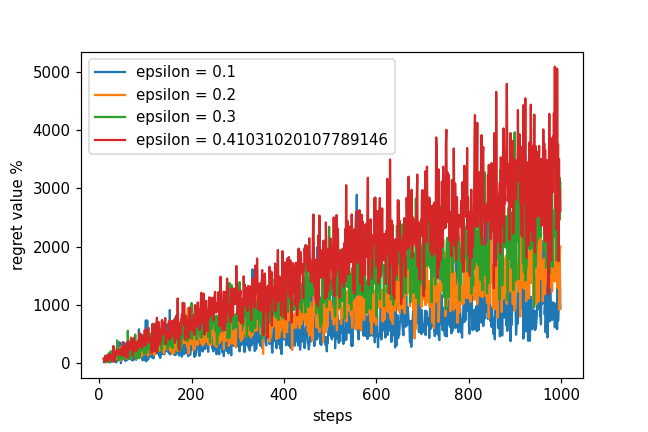

In [276]:
visualization()

In [ ]:
def thomson_sampling()